## Surprise Housing Price Prediction - Assignment Solution

### Data Understanding and Exploration


In [387]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
%matplotlib inline

In [388]:
import warnings
warnings.filterwarnings('ignore')

In [389]:
# Reading the dataset
dfHousing = pd.read_csv("train.csv", na_values="NAN")

In [390]:
# Let's take a look at the first few rows
dfHousing.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### EDA on Housing Data Set

In [391]:
print(dfHousing.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

<Axes: xlabel='SalePrice', ylabel='Density'>

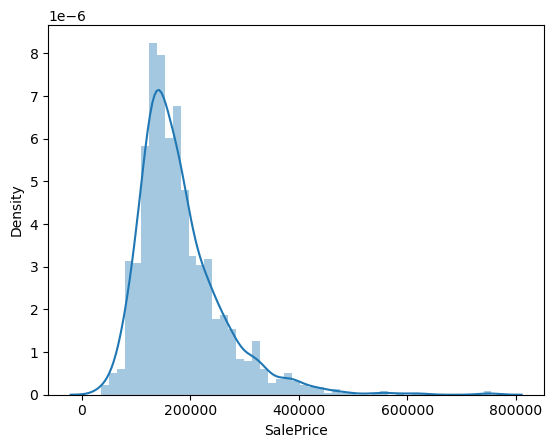

In [392]:
sns.distplot(dfHousing['SalePrice'])

In [393]:
print("Skewness:", dfHousing['SalePrice'].skew())
print("Kurtosis:", dfHousing['SalePrice'].kurt())

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


### Data Corrections

In [394]:
def assessMissingData():
    missing_data = dfHousing.isnull().sum()/dfHousing.shape[0] * 100
    print(missing_data[missing_data != 0].sort_values(ascending=False))

assessMissingData()


PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
BsmtQual         2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
dtype: float64


#### Special treatment of NaN values:

Some of the columns have a NaN value. But it has a semantic association according to the data definition. We fill NaN value with "None" where it has a meaning

In [395]:
columns_with_na = ["Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PoolQC", "Fence", "MiscFeature"]

for col in columns_with_na:
    print('replacing NA with None for column:', col)
    dfHousing[col].fillna("None", inplace=True)

dfHousing.sample(10)

replacing NA with None for column: Alley
replacing NA with None for column: BsmtQual
replacing NA with None for column: BsmtCond
replacing NA with None for column: BsmtExposure
replacing NA with None for column: BsmtFinType1
replacing NA with None for column: BsmtFinType2
replacing NA with None for column: FireplaceQu
replacing NA with None for column: GarageType
replacing NA with None for column: GarageFinish
replacing NA with None for column: GarageQual
replacing NA with None for column: GarageCond
replacing NA with None for column: PoolQC
replacing NA with None for column: Fence
replacing NA with None for column: MiscFeature


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
744,745,120,RL,41.0,5395,Pave,None,IR1,HLS,AllPub,...,0,None,None,None,0,10,2008,WD,Normal,180000
484,485,20,RL,NaN,7758,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,3,2007,WD,Normal,132500
736,737,90,RL,60.0,8544,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,7,2006,WD,Normal,93500
1149,1150,70,RM,50.0,9000,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,7,2009,WD,Normal,143000
1166,1167,20,RL,64.0,10475,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2010,WD,Normal,245350
1429,1430,20,RL,NaN,12546,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,4,2007,WD,Normal,182900
561,562,20,RL,77.0,10010,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2006,WD,Normal,170000
1058,1059,60,RL,96.0,11308,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,7,2009,WD,Normal,335000
52,53,90,RM,110.0,8472,Grvl,None,IR2,Bnk,AllPub,...,0,None,None,None,0,5,2010,WD,Normal,110000
749,750,50,RL,50.0,8405,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2009,WD,Normal,98000


In [396]:
# removed NA values for Categorical columns

assessMissingData()

LotFrontage    17.739726
GarageYrBlt     5.547945
MasVnrType      0.547945
MasVnrArea      0.547945
Electrical      0.068493
dtype: float64


In [397]:
# LotFrontage has almost 17% nulls, so removing it 

dfHousing.drop('LotFrontage', axis=1, inplace=True)

dfHousing.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF'

In [398]:
# Mark Null values as None for MasVnrType

dfHousing['MasVnrType'].fillna('None', inplace=True)

In [399]:
dfHousing["GarageYrBlt"].fillna(dfHousing["GarageYrBlt"].median(), inplace=True)
dfHousing["MasVnrArea"].fillna(dfHousing["MasVnrArea"].median(), inplace=True)

In [400]:
assessMissingData()

Electrical    0.068493
dtype: float64


In [401]:
dfHousing[dfHousing['Electrical'].isnull()]

,Id,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1379,1380,80,RL,9735,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,5,2008,WD,Normal,167500


In [402]:
# Drop the single row with Electrical as NaN

dfHousing.dropna(inplace=True)

#### Data Types & Categorical Variables

In [403]:
dfHousing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1459 non-null   object 
 3   LotArea        1459 non-null   int64  
 4   Street         1459 non-null   object 
 5   Alley          1459 non-null   object 
 6   LotShape       1459 non-null   object 
 7   LandContour    1459 non-null   object 
 8   Utilities      1459 non-null   object 
 9   LotConfig      1459 non-null   object 
 10  LandSlope      1459 non-null   object 
 11  Neighborhood   1459 non-null   object 
 12  Condition1     1459 non-null   object 
 13  Condition2     1459 non-null   object 
 14  BldgType       1459 non-null   object 
 15  HouseStyle     1459 non-null   object 
 16  OverallQual    1459 non-null   int64  
 17  OverallCond    1459 non-null   int64  
 18  YearBuil

In [404]:
dfColTypes = pd.DataFrame(dfHousing.dtypes)

dfColTypes.reset_index(inplace=True)
dfColTypes.rename(columns = {'index': 'name', 0: 'datatype'}, inplace=True)


In [405]:
categorical_types = dfColTypes[dfColTypes['datatype'] == 'object']['name']

for cat_var in categorical_types:
    dfHousing[cat_var] = dfHousing[cat_var].astype('category')

In [406]:
dfHousing.shape

(1459, 80)

In [407]:
# Adding dummy columns for data set

dfHousing =  pd.get_dummies(dfHousing, drop_first=True)

dfHousing.shape

(1459, 260)

#### Numerical Variables

In [408]:
numerical_columns =  dfColTypes[(dfColTypes['datatype'] == 'float64') | (dfColTypes['datatype'] == 'int64')]['name']

numerical_columns

0                Id
1        MSSubClass
3           LotArea
16      OverallQual
17      OverallCond
18        YearBuilt
19     YearRemodAdd
25       MasVnrArea
33       BsmtFinSF1
35       BsmtFinSF2
36        BsmtUnfSF
37      TotalBsmtSF
42         1stFlrSF
43         2ndFlrSF
44     LowQualFinSF
45        GrLivArea
46     BsmtFullBath
47     BsmtHalfBath
48         FullBath
49         HalfBath
50     BedroomAbvGr
51     KitchenAbvGr
53     TotRmsAbvGrd
55       Fireplaces
58      GarageYrBlt
60       GarageCars
61       GarageArea
65       WoodDeckSF
66      OpenPorchSF
67    EnclosedPorch
68        3SsnPorch
69      ScreenPorch
70         PoolArea
74          MiscVal
75           MoSold
76           YrSold
79        SalePrice
Name: name, dtype: object

### Test-Train Split

In [409]:
dfHousing["TransformedPrice"] = np.log(dfHousing["SalePrice"])

In [410]:
X = dfHousing.drop(["Id", "SalePrice"], axis=1).copy()
X.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,TransformedPrice
0,60,8450,7,5,2003,2003,196.0,706,0,150,...,0,0,0,1,0,0,0,1,0,12.247694
1,20,9600,6,8,1976,1976,0.0,978,0,284,...,0,0,0,1,0,0,0,1,0,12.109011
2,60,11250,7,5,2001,2002,162.0,486,0,434,...,0,0,0,1,0,0,0,1,0,12.317167
3,70,9550,7,5,1915,1970,0.0,216,0,540,...,0,0,0,1,0,0,0,0,0,11.849398
4,60,14260,8,5,2000,2000,350.0,655,0,490,...,0,0,0,1,0,0,0,1,0,12.429216


In [411]:
y = dfHousing["TransformedPrice"].values

In [412]:
numerical_variables = numerical_columns[(numerical_columns != 'Id') & (numerical_columns != 'SalePrice')]

numerical_variables

1        MSSubClass
3           LotArea
16      OverallQual
17      OverallCond
18        YearBuilt
19     YearRemodAdd
25       MasVnrArea
33       BsmtFinSF1
35       BsmtFinSF2
36        BsmtUnfSF
37      TotalBsmtSF
42         1stFlrSF
43         2ndFlrSF
44     LowQualFinSF
45        GrLivArea
46     BsmtFullBath
47     BsmtHalfBath
48         FullBath
49         HalfBath
50     BedroomAbvGr
51     KitchenAbvGr
53     TotRmsAbvGrd
55       Fireplaces
58      GarageYrBlt
60       GarageCars
61       GarageArea
65       WoodDeckSF
66      OpenPorchSF
67    EnclosedPorch
68        3SsnPorch
69      ScreenPorch
70         PoolArea
74          MiscVal
75           MoSold
76           YrSold
Name: name, dtype: object

In [413]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
X_train[numerical_variables].head()

In [415]:
scaler = StandardScaler()

X_train[numerical_variables] = scaler.fit_transform(X_train[numerical_variables])
X_test[numerical_variables] = scaler.transform(X_test[numerical_variables])

In [419]:
X_train.shape

(1167, 259)